In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Problem 1
Implement a MATLAB code simulating a trajectory {(Xn1, Xn2)}mn=0 of some arbitrary length m and plot the same. Does it look like a reasonable trajectory of a moving target?

In [5]:
delta_t = 0.5 #sec
alpha = 0.6   

Phi_tilde = np.array([[1, delta_t, delta_t**2/2],[0, 1, delta_t],[0, 0, alpha]])
Phi = np.block([[Phi_tilde, np.zeros((3,3))],[np.zeros((3,3)),Phi_tilde]])

Psi_tilde_z = np.array([[delta_t**2/2],[delta_t],[0]])
Psi_z = np.block([[Psi_tilde_z,np.zeros((3,1))],[np.zeros((3,1)),Psi_tilde_z]]) 

Psi_tilde_w = np.array([[delta_t**2/2],[delta_t],[1]])
Psi_w = np.block([[Psi_tilde_w,np.zeros((3,1))],[np.zeros((3,1)),Psi_tilde_w]]) 

In [6]:
sigma=0.5

X_0 = np.random.multivariate_normal([0,0,0,0,0,0],np.diag([500, 5, 5, 200, 5, 5]))
rand = np.random.randint(0, high=5, dtype=int)
Z = np.array([[0, 0],[3.5, 0],[0, 3.5],[0, -3.5],[-3.5,0]])

P = 1/20*np.add(np.ones([5,5]),np.diag([15,15,15,15,15]))

In [7]:
m=500
X=np.empty((6,m+1))
X[:,0]=X_0
rand = np.random.randint(0, high=5, dtype=int)
for i in range(m):
    W = np.random.multivariate_normal([0,0],np.diag([sigma**2, sigma**2]))

    X[:,i+1]=Phi@X[:,i]+Psi_z@Z[rand].T+Psi_w@W
    
    p=P[rand,:].tolist()
    rand = np.random.choice(5, 1, p)[0]

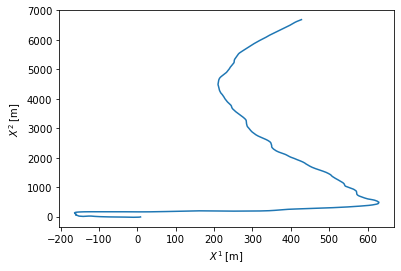

In [8]:
fig, ax = plt.subplots()
ax.plot(X[0,:],X[3,:])
plt.xlabel("$X^1$ [m]")
plt.ylabel("$X^2$ [m]")
plt.show()

# Problem 3
Implement the sequential importance sampling (SIS) algorithm for sampling from f(x ̃n | y0:n), n = 0, 1, . . . , m, for the observation stream in RSSI-measurements.mat and provide estimates of {(τn1,τn2)}mn=0.2 Use the prior dynamics q(x ̃n | x ̃n−1) as proposal kernel. Plot the estimates in the plane together with the locations of the basis stations. In order to keep the computational time at a minimum, you should vectorize the algorithm as far as possible. In particular, since you should be able to run the algorithm for a large particle sample size, say, N = 10,000, you should avoid any for-loop on the particle level. Plot histograms of the importance weights and compute the efficient sample sizes at some selected time points. Conclusion?

In [60]:
y = np.loadtxt('RSSI-measurements.txt',delimiter=',')
pi = np.loadtxt('stations.txt',delimiter=',')

In [61]:
v=90
eta=3
xi=1.5
s=6 #number of stations

In [62]:
from scipy.stats import multivariate_normal
from scipy.spatial import distance_matrix

def p(x,y):
    
    w = np.zeros([1,N]) 
    cov = np.diag([1,1,1,1,1,1])*xi**2
    position = x[[0,3],:]
   
    d = distance_matrix(position.T,pi.T)
    mu = v-10*eta*np.log10(d)
   # mu = v-10*eta*np.log10(distance.cdist(pi.T,[x[[0,3],i].T],'euclidean')).T
   # w[0,i] = multivariate_normal.pdf(y,mu[0],cov)    
    return np.apply_along_axis(multivariate,1,mu,y)                     

In [63]:
from scipy.stats import multivariate_normal

def multivariate(mu,y):
    cov = np.diag([1,1,1,1,1,1])*xi**2
    
    return multivariate_normal.logpdf(y,mu,cov)

In [64]:
N = 10000 #number of draws of X
m= 500 #number of timesteps

Z = np.array([[0, 0],[3.5, 0],[0, 3.5],[0, -3.5],[-3.5,0]])
rand = np.random.choice(5, N)
print(Z[rand])
tau = np.zeros((2,m+1)) #Initilizie empty tau

mean = np.array([0,0,0,0,0,0])
cov = np.diag([500, 5, 5, 200, 5, 5])
part = np.random.multivariate_normal(mean,cov,N).T

l = p(part,y[:,0])
L = np.max(l)
w_bar = np.exp(l-L)
ESS = np.zeros((1,m+1))
ESS[0,0] = 1/np.sum((w_bar/np.sum(w_bar)**2))

tau[0,0]=np.sum(w_bar*part[0,:])/np.sum(w_bar)
tau[1,0]=np.sum(w_bar*part[3,:])/np.sum(w_bar)

[[0.  0. ]
 [0.  3.5]
 [0.  3.5]
 ...
 [0.  0. ]
 [0.  0. ]
 [0.  0. ]]


In [65]:
for k in range(m):
    W = np.random.multivariate_normal([0,0],np.diag([sigma**2, sigma**2]),N).T
    
    Zm = np.transpose(Z[rand])  
    part=Phi@part+Psi_z@Zm+Psi_w@W
    l = p(part,y[:,k+1])+l
    L = np.max(l)
    w_bar = np.exp(l-L)
    ESS[0,k+1] = 1/np.sum((w_bar/np.sum(w_bar)**2))
   
    tau[0,k+1]=np.sum(w_bar*part[0,:])/np.sum(w_bar)
    tau[1,k+1]=np.sum(w_bar*part[3,:])/np.sum(w_bar)
    
    for index, r in enumerate(rand):
        rand[index] = np.random.choice(5, 1, p=P[r,:])

1.0


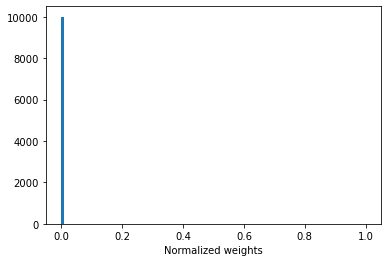

In [66]:
plt.hist(w_bar, bins=100)
plt.xlabel('Normalized weights')
plt.show
print(np.sum(w_bar))

<function matplotlib.pyplot.show(close=None, block=None)>

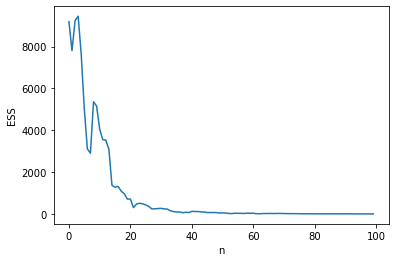

In [75]:
plt.plot(ESS[0,0:100])
plt.ylabel('ESS')
plt.xlabel('n')
plt.show


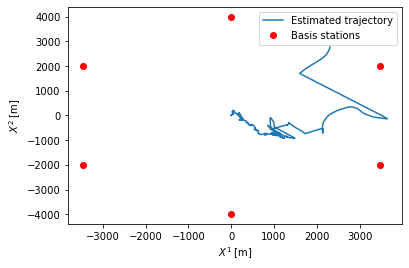

In [68]:
#fig, ax = plt.subplots()
#plt.plot(tau[0,:],tau[1,:])
plt.plot(tau[0,:],tau[1,:],pi[0,:],pi[1,:],'ro')
plt.xlabel("$X^1$ [m]")
plt.ylabel("$X^2$ [m]")
plt.legend(["Estimated trajectory","Basis stations"])
plt.show()

# Problem 4
Implement the sequential importance sampling with resampling (SISR) algorithm for sampling from the same flow of densities by adding a selection step to the algorithm designed in Problem 3. Provide again, using at least N = 10,000 particles, a plot of the estimated expected positions {(τn1,τn2)}mn=0 for the given data stream. Also this implementation should be vectorized as far as possible. Conclusion?

In [76]:
from scipy.stats import multivariate_normal

def multivariate(mu,y):
    cov = np.diag([1,1,1,1,1,1])*xi**2
    
    return multivariate_normal.pdf(y,mu,cov)

In [47]:
N = 10000 #number of draws of X
m=500 #number of timesteps

Z = np.array([[0, 0],[3.5, 0],[0, 3.5],[0, -3.5],[-3.5,0]])
rand = np.random.choice(5, N)
most_prob = np.zeros((1,m+1))
most_prob[0,0] = np.bincount(rand).argmax()
print(most_prob)
tau = np.zeros((2,m+1)) #Initilizie empty tau

mean = np.array([0,0,0,0,0,0])
cov = np.diag([500, 5, 5, 200, 5, 5])
part = np.random.multivariate_normal(mean,cov,N).T

w_bar = p(part,y[:,0])

tau[0,0]=np.sum(w_bar*part[0,:])/np.sum(w_bar)
tau[1,0]=np.sum(w_bar*part[3,:])/np.sum(w_bar)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [48]:
for k in range(m):
    W = np.random.multivariate_normal([0,0],np.diag([sigma**2, sigma**2]),N).T

    Zm = np.transpose(Z[rand]) 
    
    prob = w_bar/np.sum(w_bar)
    index = np.random.choice(N,N,p=prob)
    part = part[:,index]
  
    part=Phi@part+Psi_z@Zm+Psi_w@W
    
    w_bar = p(part,y[:,k+1])
    
    tau[0,k+1]=np.sum(w_bar*part[0,:])/np.sum(w_bar)
    tau[1,k+1]=np.sum(w_bar*part[3,:])/np.sum(w_bar)

    for index, r in enumerate(rand):
        rand[index] = np.random.choice(5, 1, p=P[r,:])
    most_prob[0,k+1] = np.bincount(rand).argmax()

<function matplotlib.pyplot.show(close=None, block=None)>

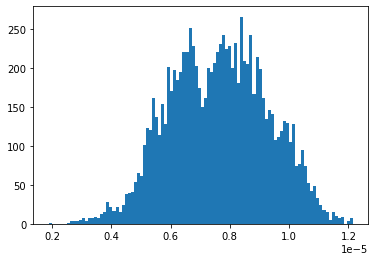

In [49]:
plt.hist(w_bar, bins=100)
plt.show

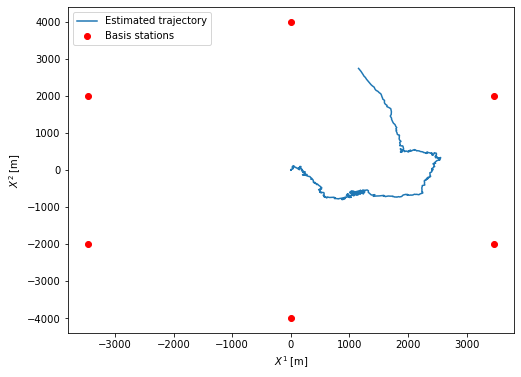

In [50]:
plt.figure(figsize=(8,6))
plt.plot(tau[0,:],tau[1,:],pi[0,:],pi[1,:],'ro')
plt.xlabel("$X^1$ [m]")
plt.ylabel("$X^2$ [m]")
plt.legend(["Estimated trajectory","Basis stations"],loc='upper left')
plt.savefig('Prob4_traj_v3.png',dpi=100)
plt.show()

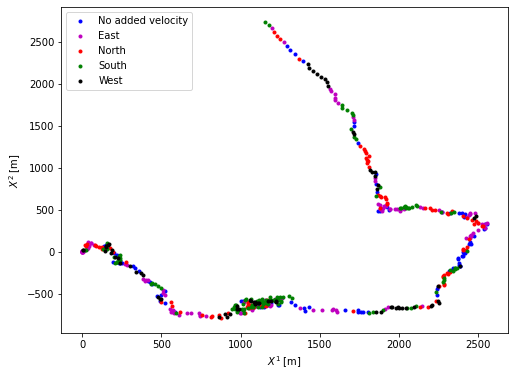

In [51]:
plt.figure(figsize=(8,6))
still_index = np.where(most_prob == 0)
east_index = np.where(most_prob == 1)
north_index = np.where(most_prob == 2)
south_index = np.where(most_prob == 3)
west_index = np.where(most_prob == 4)
plt.plot(tau[0,still_index[1]],tau[1,still_index[1]],'.b',label='No added velocity')
plt.plot(tau[0,east_index[1]],tau[1,east_index[1]],'.m',label='East')
plt.plot(tau[0,north_index[1]],tau[1,north_index[1]],'.r',label='North')
plt.plot(tau[0,south_index[1]],tau[1,south_index[1]],'.g',label='South')
plt.plot(tau[0,west_index[1]],tau[1,west_index[1]],'.k',label='West')
plt.xlabel("$X^1$ [m]")
plt.ylabel("$X^2$ [m]")
plt.legend(loc='upper left')
plt.savefig('Prob4_mostprob.png',dpi=100)
plt.show()

# Problem 5

In a more realistic scenario, the parameters of the model are unknown and needs to be estimated (the standard deviation in the observation noise). In this problem we assume that all paramters except ς has been previously calibrated. The file RSSI-measurements-unknown-sigma.mat con- tains another RSSI data stream y0:m, with again m = 500, measured on a target with unknown ς ∈ (0, 3). In that case, one way of calibrating the ς is to maximize the normalized log-likelihood function ς 􏰕→ lm(ς, y0:m) = m−1 ln Lm(ς, y0:m), where the likelihood Lm(ς, y0:m) = fς (y0:m) is the normalizing constant of the smoothing distribution (5). However, for the complicated model under consideration, Lm(ς, y0:m), and thus lm(ς, y0:m), is intractable.

In [77]:
y_sigma = np.loadtxt('RSSI-measurements-unknown-sigma.txt',delimiter=',')
y_sigma

array([[-14.196, -16.093, -15.434, ..., -16.087, -15.082, -10.011],
       [-18.363, -17.181, -18.408, ..., -25.647, -30.63 , -28.848],
       [-15.736, -20.006, -17.223, ..., -19.242, -20.04 , -26.676],
       [-19.325, -22.518, -20.613, ..., -29.797, -31.365, -30.529],
       [-15.066, -20.173, -20.391, ..., -27.291, -27.202, -22.368],
       [-19.746, -21.774, -17.924, ..., -19.016, -20.278, -17.425]])

In [86]:
from scipy.stats import multivariate_normal
from scipy.spatial import distance_matrix

def p(x,y,xi):
    
    w = np.zeros([1,N]) 
    cov = np.diag([1,1,1,1,1,1])*xi**2
    position = x[[0,3],:]
   
    d = distance_matrix(position.T,pi.T)
    mu = v-10*eta*np.log10(d)
   # mu = v-10*eta*np.log10(distance.cdist(pi.T,[x[[0,3],i].T],'euclidean')).T
   # w[0,i] = multivariate_normal.pdf(y,mu[0],cov)    
    return np.apply_along_axis(multivariate,1,mu,xi,y)  

In [87]:
from scipy.stats import multivariate_normal

def multivariate(mu,xi,y):
    cov = np.diag([1,1,1,1,1,1])*xi**2
    
    return multivariate_normal.pdf(y,mu,cov)

In [88]:
N = 10000 #number of draws of X
m= 500 #number of timesteps

Xi = np.linspace(1,3,5)
Sigma_k_vec=[]

for ii in Xi:
    simga_k = 0
    Z = np.array([[0, 0],[3.5, 0],[0, 3.5],[0, -3.5],[-3.5,0]])
    rand = np.random.choice(5, N)
    tau = np.zeros((2,m+1)) #Initilizie empty tau

    mean = np.array([0,0,0,0,0,0])
    cov = np.diag([500, 5, 5, 200, 5, 5])
    part = np.random.multivariate_normal(mean,cov,N).T

    w_bar = p(part,y_sigma[:,0],ii)

    sigma_k = np.log(np.sum(w_bar)/N)  
    tau[0,0]=np.sum(w_bar*part[0,:])/np.sum(w_bar)
    tau[1,0]=np.sum(w_bar*part[3,:])/np.sum(w_bar)

    for k in range(m):
        W = np.random.multivariate_normal([0,0],np.diag([sigma**2, sigma**2]),N).T

        Zm = np.transpose(Z[rand]) 
    
        index = np.random.choice(N,N,p=w_bar/np.sum(w_bar))
        part = part[:,index]
    
        part=Phi@part+Psi_z@Zm+Psi_w@W
    
        w_bar = p(part,y_sigma[:,k+1],ii)
    
        sigma_k += np.log(np.sum(w_bar)/N)
    
        tau[0,k+1]=np.sum(w_bar*part[0,:])/np.sum(w_bar)
        tau[1,k+1]=np.sum(w_bar*part[3,:])/np.sum(w_bar)

        for index, r in enumerate(rand):
            rand[index] = np.random.choice(5, 1, p=P[r,:])
    
    Sigma_k_vec.append(sigma_k)
    print(sigma_k)

-10064.492250144489
-7272.163224311845
-6704.671546370335
-6727.435188506506
-6917.471404095901


<function matplotlib.pyplot.show(close=None, block=None)>

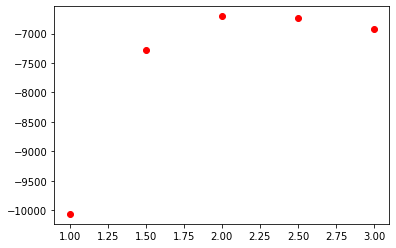

In [89]:
plt.plot(Xi,Sigma_k_vec,'ro')
plt.show

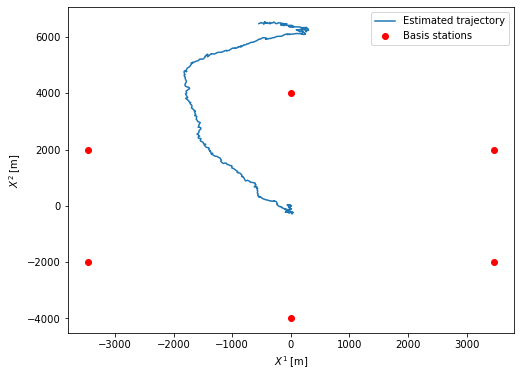

In [91]:
plt.figure(figsize=(8,6))
plt.plot(tau[0,:],tau[1,:],pi[0,:],pi[1,:],'ro')
plt.xlabel("$X^1$ [m]")
plt.ylabel("$X^2$ [m]")
plt.legend(["Estimated trajectory","Basis stations"])
plt.show()